# What is the Galactic Metallicity Gradient as a Function of Age?

Investigations on this project thus far have indicated that the radial abundance gradient as a function of stellar age may be a promising diagnostic for nailing down the normalization of $\eta$ with radius, and by extension, the normalization of nucleosynthetic yields as well. In this notebook I use the new [Leung et al. (2023)](https://ui.adsabs.harvard.edu/abs/2023arXiv230205479L/abstract) catalog containing spectroscopic ages to plot the [O/H] and [Fe/H] abundance gradients in bins of stellar age.

In [1]:
from plots.mpltoolkit import named_colors, mpl_loc, markers, fancy_legend, load_mpl_presets
from scipy.stats import bootstrap
import matplotlib.pyplot as plt
import numpy as np
import random
import vice
import sys
load_mpl_presets()
print(sys.version_info)

sys.version_info(major=3, minor=10, micro=4, releaselevel='final', serial=0)


/Users/jamesjohnson/Work/Research/VICErepos/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [2]:
columns = ["LINE", "APOGEE_ID", "RA", "DEC", "GALR", "GALPHI", "GALZ", "SNREV", "TEFF", "TEFF_ERR",
    "LOGG", "LOGG_ERR", "FE_H", "FE_H_ERR", "O_FE", "O_FE_ERR", "ASTRONN_AGE", "ASTRONN_AGE_ERR",
    "LATENT_AGE", "LATENT_AGE_ERR"]
raw = np.genfromtxt("../data/Leung2023.csv", delimiter = ',', skip_header = 1, usecols = range(len(columns)))
sample = {}
for i in range(len(columns)):
    sample[columns[i]] = [row[i] for row in raw]
sample["o_h"] = [a + b for a, b in zip(sample["O_FE"], sample["FE_H"])]
sample["o_h_err"] = [np.sqrt(a**2 + b**2) for a, b in zip(sample["O_FE_ERR"], sample["FE_H_ERR"])]
sample = vice.dataframe(sample)
print(sample)

vice.dataframe{
    line -----------> [0, 1, 2, ... , 192917, 192918, 192919]
    apogee_id ------> [nan, nan, nan, ... , nan, nan, nan]
    ra -------------> [0.00285, 0.005558, 0.008802, ... , 359.993, 359.995, 359.997]
    dec ------------> [57.1732, 57.3545, 63.4631, ... , 57.0124, 57.435, 56.1633]
    galr -----------> [8.4584, 11.9539, 12.8583, ... , 10.6942, 9.3281, 9.64501]
    galphi ---------> [175.658, 153.655, 151.397, ... , 159.022, 167.511, 165.095]
    galz -----------> [-0.040749, -0.470835, 0.169356, ... , -0.358826, -0.163006, -0.265258]
    snrev ----------> [282.746, 120.295, 169.02, ... , 101.537, 232.918, 88.4561]
    teff -----------> [5031.26, 4974.6, 4681.46, ... , 4954.17, 4859.91, 4585.41]
    teff_err -------> [10.1451, 15.3109, 8.76634, ... , 15.7503, 9.05073, 11.2989]
    logg -----------> [3.45613, 2.38825, 2.24553, ... , 2.47466, 2.48069, 2.57144]
    logg_err -------> [0.0235541, 0.0355173, 0.0243345, ... , 0.0347484, 0.0240131, 0.0286862]
    fe_h ----

age = 0 - 2 Gyr ; N = 16045
age = 2 - 4 Gyr ; N = 40784
age = 4 - 6 Gyr ; N = 43275
age = 6 - 8 Gyr ; N = 44409
age = 8 - 10 Gyr ; N = 40354


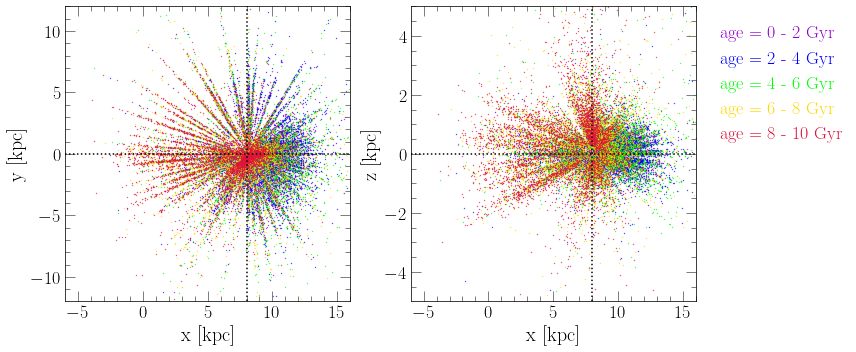

In [4]:
N_SAMPLE = 5000
random.seed(a = 1)

fig = plt.figure(figsize = (12, 5))
axes = []
for i in range(2): axes.append(fig.add_subplot(121 + i))
axes[0].set_xlabel("x [kpc]")
axes[0].set_ylabel("y [kpc]")
axes[0].set_xlim([-6, 16])
axes[0].set_ylim([-12, 12])
axes[1].set_xlabel("x [kpc]")
axes[1].set_ylabel("z [kpc]")
axes[1].set_xlim([-6, 16])
axes[1].set_ylim([-5, 5])

age_bins = [0, 2, 4, 6, 8, 10]
colors = ["darkviolet", "blue", "lime", "gold", "crimson"]
for i in range(len(colors)):
    subsample = sample.filter("ASTRONN_AGE", ">=", age_bins[i]).filter("ASTRONN_AGE", "<=", age_bins[i + 1])
    print("age = %g - %g Gyr ; N = %d" % (age_bins[i], age_bins[i + 1], len(subsample["TEFF"])))
    indeces = random.sample(range(len(subsample["TEFF"])), N_SAMPLE)
    kwargs = {
        "c": named_colors()[colors[i]],
        "s": 0.1,
        "rasterized": True,
        "label": "age = %d - %d Gyr" % (age_bins[i], age_bins[i + 1])
    }
    x = N_SAMPLE * [0.]
    y = N_SAMPLE * [0.]
    z = N_SAMPLE * [0.]
    for i in range(N_SAMPLE):
        x[i] = -subsample["GALR"][indeces[i]] * np.cos(np.pi / 180 * subsample["GALPHI"][indeces[i]])
        y[i] = -subsample["GALR"][indeces[i]] * np.sin(np.pi / 180 * subsample["GALPHI"][indeces[i]])
        z[i] = subsample["GALZ"][indeces[i]]
    axes[0].scatter(x, y, **kwargs)
    axes[1].scatter(x, z, **kwargs)

kwargs = {
    "c": named_colors()["black"],
    "linestyle": ":"
}
axes[0].axhline(0, **kwargs)
axes[0].axvline(8, **kwargs)
axes[1].axhline(0, **kwargs)
axes[1].axvline(8, **kwargs)

kwargs = {
    "loc": mpl_loc("upper left"),
    "bbox_to_anchor": (1.01, 0.99),
    "handlelength": 0
}
leg = axes[1].legend(**kwargs)
fancy_legend(leg, colors)

plt.tight_layout()
plt.show()

## The Spatial Distribution of the Sample

Above is a plot showing x-y and x-z projections of the sample in Galactocentric coordinates. There are 5,000 randomly sampled stars plotted from each age bin, with cool (warm) colors showing young (old) stellar populations. It is visually apparent that the younger stellar populations dominate at larger radii and smaller midplane distances, and conversely, older populations dominate closer to the Galactic center but farther from the midplane.

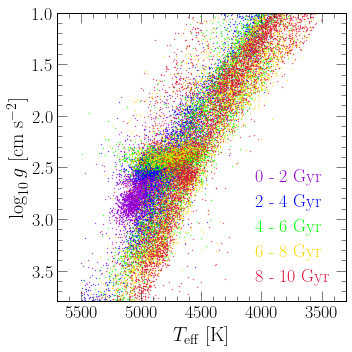

In [19]:
N_SAMPLE = 5000
random.seed(a = 1)

fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111)
ax.set_xlabel(r"$T_\text{eff}$ [K]")
ax.set_ylabel(r"$\log_{10} g$ [cm s$^{-2}$]")
ax.set_xlim([3300, 5700])
ax.set_ylim([1, 3.8])
ax.invert_xaxis()
ax.invert_yaxis()

age_bins = [0, 2, 4, 6, 8, 10]
colors = ["darkviolet", "blue", "lime", "gold", "crimson"]
for i in range(len(colors)):
    subsample = sample.filter("ASTRONN_AGE", ">=", age_bins[i]).filter("ASTRONN_AGE", "<=", age_bins[i + 1])
    indeces = random.sample(range(len(subsample["TEFF"])), N_SAMPLE)
    kwargs = {
        "c": named_colors()[colors[i]],
        "s": 0.1,
        "rasterized": True,
        "label": "%d - %d Gyr" % (age_bins[i], age_bins[i + 1])
    }
    teff = [subsample["TEFF"][idx] for idx in indeces]
    logg = [subsample["LOGG"][idx] for idx in indeces]
    ax.scatter(teff, logg, **kwargs)
    
kwargs = {
    "loc": mpl_loc("lower right"),
    "ncol": 1,
    "handlelength": 0
}
leg = ax.legend(**kwargs)
fancy_legend(leg, colors)
    
plt.tight_layout()
plt.show()

## The Kiel Diagram of the Sample

This figure shows a Kiel diagram of our sample with 5,000 stars randomly selected from each age bin. Cool (warm) colors show young (old) stellar populations. In general, younger stellar populations are more clustered around the red clump at $\log g \approx 2.5$, while older populations sample the red giant branch more uniformly.

In [19]:
def mode(values, bins):
    dist, _ = np.histogram(values, bins = bins)
    idxmax = dist.tolist().index(max(dist))
    return (bins[idxmax] + bins[idxmax + 1]) / 2

In [29]:
radial_bins = list(range(16))
age_bins = [0, 2, 4, 6, 8]
bins = np.linspace(-3, 2, 501)

def bootstrap_callable(values, **kwargs):
    return np.array([mode(values, bins)])

with open("./gradient_binned_by_age.out", 'w') as f:
    f.write("# COLUMNS:\n")
    f.write("# 0. min_age [Gyr]\n")
    f.write("# 1. max_age [Gyr]\n")
    f.write("# 2. min_radius [kpc]\n")
    f.write("# 3. max_radius [kpc]\n")
    n = 4
    for item in ["[Fe/H]", "[O/H]", "[O/Fe]"]:
        f.write("# %d. mode(%s)\n" % (n, item))
        f.write("# %d. err_mode(%s)_minus\n" % (n + 1, item))
        f.write("# %d. err_mode(%s)_plus\n" % (n + 2, item))
        n += 3
    for i in range(len(age_bins) - 1):
        subsample = sample.filter(
            "ASTRONN_AGE", ">=", age_bins[i]).filter(
            "ASTRONN_AGE", "<=", age_bins[i + 1]).filter(
            "FE_H", "<", 10).filter(
            "O_FE", "<", 10).filter(
            "O_H", "<", 10)
        for j in range(len(radial_bins) - 1):
            subsubsample = subsample.filter(
                "GALR", ">=", radial_bins[j]).filter(
                "GALR", "<=", radial_bins[j + 1])
            sys.stdout.write("\rage = %d - %d Gyr ; R = %d - %d kpc        " % (
                age_bins[i], age_bins[i + 1], radial_bins[j], radial_bins[j + 1]))
            f.write("%.3e\t%.3e\t%.3e\t%.3e\t" % (age_bins[i], age_bins[i + 1],
                radial_bins[j], radial_bins[j + 1]))
            for key in ["FE_H", "O_H", "O_FE"]:
                values = subsubsample[key]
                if len(values) >= 200:
                    mode_ = bootstrap_callable(values)
#                     print(mode_)
#                     bootstrap_ci = bootstrap((values,), bootstrap_callable, confidence_level = 0.68,
#                         method = "percentile", random_state = 1)
#                     minus_err = mode_ - bootstrap_ci.confidence_interval.low
#                     plus_err = bootstrap_ci.confidence_interval.high - mode_
                    err = np.std(values) / np.sqrt(len(values))
                    minus_err = plus_err = err / 2
                    f.write("%.3e\t%.3e\t%.3e\t" % (mode_, minus_err, plus_err))
                else:
                    f.write("nan\tnan\tnan\t")
            f.write("\n")
    sys.stdout.write("\n")

age = 6 - 8 Gyr ; R = 14 - 15 kpc        


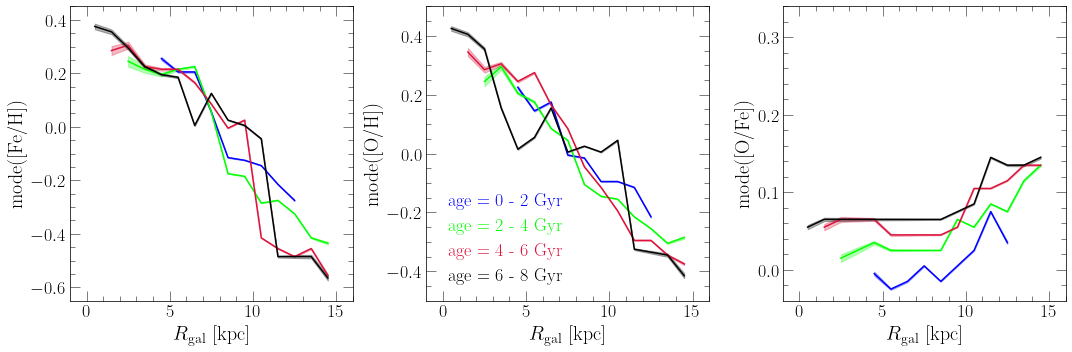

In [31]:
fig = plt.figure(figsize = (15, 5))
axes = []
for i in range(3):
    axes.append(fig.add_subplot(131 + i))
    axes[i].set_xlabel(r"$R_\text{gal}$ [kpc]")
    axes[i].set_xlim([-1, 16])
axes[0].set_ylabel("mode([Fe/H])")
axes[0].set_ylim([-0.65, 0.45])
axes[1].set_ylabel("mode([O/H])")
axes[1].set_ylim([-0.5, 0.5])
axes[2].set_ylabel("mode([O/Fe])")
axes[2].set_ylim([-0.04, 0.34])
axes[2].set_yticks([0, 0.1, 0.2, 0.3])

colors = ["blue", "lime", "crimson", "black"]
raw = np.genfromtxt("./gradient_binned_by_age.out")
n_age_bins = len(age_bins) - 1
n_rad_bins = len(radial_bins) - 1
for i in range(n_age_bins):
    measurements = raw[i * n_rad_bins : (i + 1) * n_rad_bins]
    radii = [(a + b) / 2 for a, b in zip(measurements[:,2], measurements[:,3])]
    feh = measurements[:,4]
    feh_lower = [a - b for a, b in zip(feh, measurements[:,5])]
    feh_upper = [a + b for a, b in zip(feh, measurements[:,6])]
    oh = measurements[:,7]
    oh_lower = [a - b for a, b in zip(oh, measurements[:,8])]
    oh_upper = [a + b for a, b in zip(oh, measurements[:,9])]
    ofe = measurements[:,10]
    ofe_lower = [a - b for a, b in zip(ofe, measurements[:,11])]
    ofe_upper = [a + b for a, b in zip(ofe, measurements[:,12])]
    kwargs = {
        "c": named_colors()[colors[i]],
        "label": "age = %d - %d Gyr" % (measurements[0][0], measurements[0][1])
    }
    axes[0].plot(radii, feh, **kwargs)
    axes[1].plot(radii, oh, **kwargs)
    axes[2].plot(radii, ofe, **kwargs)
    kwargs["color"] = kwargs["c"]
    del kwargs["c"]
    kwargs["label"] = None
    kwargs["alpha"] = 0.3
    axes[0].fill_between(radii, feh_lower, feh_upper, **kwargs)
    axes[1].fill_between(radii, oh_lower, oh_upper, **kwargs)
    axes[2].fill_between(radii, ofe_lower, ofe_upper, **kwargs)

kwargs = {
    "loc": mpl_loc("lower left"),
    "handlelength": 0
}
leg = axes[1].legend(**kwargs)
fancy_legend(leg, colors)

plt.tight_layout()
plt.show()

## The Abundance Gradient in Bins of Age

The above figure shows the mode [Fe/H] (left), [O/H] (middle), and [O/Fe] (right) as a function of radius in bins of age, color-coded according to the legend in the middle panel. Points are plotted along the lines if and only if there are $N \geq 200$ stars in the corresponding bin of radius and age.

Gradients in both [Fe/H] and [O/H] were largely established by $\tau \approx 8$ Gyr ago, with only marginal evolution in [O/H] between the $6 - 8$ Gyr and $4 - 6$ Gyr bins. As a consequence, there is also only marginal evolution in the [O/Fe] gradient with time.

Qualitatively, this lack of evolution in the observed abundance gradient suggests that the Galaxy achieved some chemical equilibrium $\sim$8 Gyr ago. This favors chemical evolution models in which the duration of star formation is much longer than the timescale to reach chemical equilibrium (i.e., $t \gg \tau_\text{eq}$). In another set of notes, I have demonstrated that the normalization of the gradient grows with time when $t \ll \tau_\text{eq}$. This realization could favor models with significant mass loading as a function of radius, unless there are other ways to produce an equilibrium abundance that strongly varies with radius.

In [7]:
radial_bins = list(range(16))
with open("./medianage_vs_r.out", 'w') as f:
    f.write("# radius [kpc]    median age [Gyr]    age_err_minus [Gyr]    age_err_plus [Gyr]\n")
    for i in range(len(radial_bins) - 1):
        subsample = sample.filter(
        "ASTRONN_AGE", ">=", 0).filter(
        "ASTRONN_AGE", "<=", 8).filter(
        "GALR", ">=", radial_bins[i]).filter(
        "GALR", "<=", radial_bins[i + 1])
        radius = (radial_bins[i] + radial_bins[i + 1]) / 2
        ages = (subsample["ASTRONN_AGE"],)
        med_age = np.median(ages)
        bootstrap_ci = bootstrap(ages, np.median, confidence_level = 0.68,
            method = "percentile", random_state = 1)
        f.write("%.3e\t%.3e\t%.3e\t%.3e\n" % (radius, med_age,
            med_age - bootstrap_ci.confidence_interval.low,
            bootstrap_ci.confidence_interval.high - med_age))
    f.close()

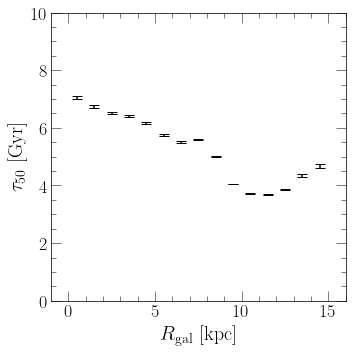

In [10]:
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111)
ax.set_xlabel(r"$R_\text{gal}$ [kpc]")
ax.set_ylabel(r"$\tau_{50}$ [Gyr]")
ax.set_xlim([-1, 16])
ax.set_ylim([0, 10])

with open("./medianage_vs_r.out", 'r') as f:
    while True:
        line = f.readline()
        if line == "": break
        if line[0] == "#": continue
        line = [float(_) for _ in line.split()]
        ax.errorbar(line[0], line[1], c = named_colors()["black"],
            yerr = [[line[2]], [line[3]]])
    f.close()

plt.tight_layout()
plt.show()